In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/yj/_2dcl_l16cl6dr1bp7h1j6hw0000gn/T/ipykernel_95883/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Lab | Natural Language Processing
### SMS: SPAM or HAM

### Let's prepare the environment

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from collections import Counter
import matplotlib.pyplot as plt

- Read Data for the Fraudulent Email Kaggle Challenge
- Reduce the training set to speead up development. 

In [3]:
## Read Data for the Fraudulent Email Kaggle Challenge
data = pd.read_csv("../data/kg_train.csv", encoding='latin-1')

# Reduce the training set to speed up development. 
# Modify for final system
data = data.head(1000)
print(data.shape)
data.fillna("",inplace=True)

(1000, 2)


### Let's divide the training and test set into two partitions

In [4]:
# Your code
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80-20 split)
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])

# Display the shapes and class distribution
print(f"Training set shape: {data_train.shape}")
print(f"Validation set shape: {data_val.shape}")
print(f"\nTraining set class distribution:")
print(data_train['label'].value_counts())
print(f"\nValidation set class distribution:")
print(data_val['label'].value_counts())

Training set shape: (800, 2)
Validation set shape: (200, 2)

Training set class distribution:
label
0    446
1    354
Name: count, dtype: int64

Validation set class distribution:
label
0    112
1     88
Name: count, dtype: int64


## Data Preprocessing

In [18]:
import nltk
import os

# Set NLTK data path to your project's data folder
nltk_data_dir = os.path.join(os.getcwd(), '../data', 'nltk_data')
os.makedirs(nltk_data_dir, exist_ok=True)
nltk.data.path.append(nltk_data_dir)

# Download stopwords and other required resources to the specified directory
nltk.download('stopwords', download_dir=nltk_data_dir)
nltk.download('punkt', download_dir=nltk_data_dir)
nltk.download('wordnet', download_dir=nltk_data_dir)
nltk.download('omw-1.4', download_dir=nltk_data_dir)
nltk.download('punkt_tab', download_dir=nltk_data_dir)

print("NLTK resources downloaded successfully!")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/malibio/ironhack/lab-natural-language-
[nltk_data]     processing/your-code/../data/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/malibio/ironhack/lab-
[nltk_data]     natural-language-processing/your-
[nltk_data]     code/../data/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/malibio/ironhack/lab-natural-language-
[nltk_data]     processing/your-code/../data/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/malibio/ironhack/lab-natural-language-
[nltk_data]     processing/your-code/../data/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/malibio/ironhack/lab-natural-language-
[nltk_data]     processing/y

NLTK resources downloaded successfully!


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [6]:
import string
from nltk.corpus import stopwords
print(string.punctuation)
print(stopwords.words("english")[100:110])
from nltk.stem.snowball import SnowballStemmer
snowball = SnowballStemmer('english')



!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on']


## Now, we have to clean the html code removing words

- First we remove inline JavaScript/CSS
- Then we remove html comments. This has to be done before removing regular tags since comments can contain '>' characters
- Next we can remove the remaining tags

In [ ]:
# Your code
def clean_html(text):
    """
    Remove HTML tags, JavaScript, CSS, and comments from text
    """
    # First remove inline JavaScript/CSS (between <script> and <style> tags)
    text = re.sub(r'<script.*?</script>', '', text, flags=re.DOTALL | re.IGNORECASE)
    text = re.sub(r'<style.*?</style>', '', text, flags=re.DOTALL | re.IGNORECASE)
    
    # Remove HTML comments (<!-- comment -->)
    # This must be done before removing regular tags since comments can contain '>' characters
    text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)
    
    # Remove remaining HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Decode common HTML entities
    text = text.replace('&amp;', '&')
    text = text.replace('&lt;', '<')
    text = text.replace('&gt;', '>')
    text = text.replace('&quot;', '"')
    text = text.replace('&#39;', "'")
    text = text.replace('&nbsp;', ' ')
    
    return text

In [10]:
# Apply HTML cleaning to both training and validation sets
data_train['text_no_html'] = data_train['text'].apply(clean_html)
data_val['text_no_html'] = data_val['text'].apply(clean_html)

# Display example of original vs cleaned text
print("Original text example:")
print(data_train['text'].iloc[0][:500])
print("\nCleaned text example:")
print(data_train['text_no_html'].iloc[0][:500])

Original text example:
Dear=2C Good day hope fine=2Cdear am writting this mail with due respect and heartful of tears since we have not known or met ourselves previously I am asking for your assistance=2Ci have will be very glad if you can render me assistance to my situation now=2E I will make my proposal well known if I am given the opportunity=2E I would like to use this opportunity to introduce myself to you=2E Am Miss Johana Johnpaul 24 years old girl from Liberia =2Cthe only daughter of Late Godwin Johnpaul the 

Cleaned text example:
Dear=2C Good day hope fine=2Cdear am writting this mail with due respect and heartful of tears since we have not known or met ourselves previously I am asking for your assistance=2Ci have will be very glad if you can render me assistance to my situation now=2E I will make my proposal well known if I am given the opportunity=2E I would like to use this opportunity to introduce myself to you=2E Am Miss Johana Johnpaul 24 years old girl from Liberia =2

- Remove all the special characters
    
- Remove numbers
    
- Remove all single characters
 
- Remove single characters from the start

- Substitute multiple spaces with single space

- Remove prefixed 'b'

- Convert to Lowercase

In [ ]:
# Your code
def clean_text(text):
    # Remove all special characters (keep only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove numbers (alternative approach if they weren't caught above)
    text = re.sub(r'\d+', ' ', text)
    
    # Remove all single characters (standalone letters)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Remove single characters from the start of the text
    text = re.sub(r'^[a-zA-Z]\s+', '', text)
    
    # Substitute multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)
    
    # Remove prefixed 'b' (in case of byte string artifacts like b'text')
    text = re.sub(r'^b\s+', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Strip leading and trailing whitespace
    text = text.strip()
    
    return text

In [12]:
# Apply text cleaning to both datasets
data_train['cleaned_text'] = data_train['text_no_html'].apply(clean_text)
data_val['cleaned_text'] = data_val['text_no_html'].apply(clean_text)

# Show examples of the cleaning process
print("=== Text Cleaning Examples ===")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Original: {data_train['text'].iloc[i][:200]}...")
    print(f"No HTML: {data_train['text_no_html'].iloc[i][:200]}...")
    print(f"Cleaned: {data_train['cleaned_text'].iloc[i][:200]}...")
    print("-" * 80)

=== Text Cleaning Examples ===

Example 1:
Original: Dear=2C Good day hope fine=2Cdear am writting this mail with due respect and heartful of tears since we have not known or met ourselves previously I am asking for your assistance=2Ci have will be very...
No HTML: Dear=2C Good day hope fine=2Cdear am writting this mail with due respect and heartful of tears since we have not known or met ourselves previously I am asking for your assistance=2Ci have will be very...
Cleaned: dear good day hope fine cdear am writting this mail with due respect and heartful of tears since we have not known or met ourselves previously am asking for your assistance ci have will be very glad i...
--------------------------------------------------------------------------------

Example 2:
Original: FROM MR HENRY KABORETHE CHIEF AUDITOR INCHARGEFOREIGN REMITTANCE UNIT,AFRICAN DEVELOPMENT BANK{ADB}.OUAGADOUGOU BURKINA FASO.Dear Partner,I presumed that all is well with you and your family.Please le...
No HTML: F

## Now let's work on removing stopwords
Remove the stopwords.

In [13]:
# Your code
def remove_stopwords(text):
    """
    Remove English stopwords from text
    """
    # Get English stopwords
    stop_words = set(stopwords.words('english'))
    
    # Split text into words
    words = text.split()
    
    # Filter out stopwords (keep only words not in stopwords list)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    
    # Join the words back into a string
    return ' '.join(filtered_words)


In [14]:
# Apply stopword removal to both datasets
data_train['no_stopwords'] = data_train['cleaned_text'].apply(remove_stopwords)
data_val['no_stopwords'] = data_val['cleaned_text'].apply(remove_stopwords)

# Show examples of stopword removal
print("=== Stopword Removal Examples ===")
print(f"English stopwords sample: {list(stopwords.words('english'))[:20]}")
print(f"Total English stopwords: {len(stopwords.words('english'))}")
print()

for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Before: {data_train['cleaned_text'].iloc[i][:200]}...")
    print(f"After:  {data_train['no_stopwords'].iloc[i][:200]}...")
    
    # Show word count reduction
    before_count = len(data_train['cleaned_text'].iloc[i].split())
    after_count = len(data_train['no_stopwords'].iloc[i].split())
    reduction = ((before_count - after_count) / before_count * 100) if before_count > 0 else 0
    print(f"Word count: {before_count} → {after_count} ({reduction:.1f}% reduction)")
    print("-" * 80)


=== Stopword Removal Examples ===
English stopwords sample: ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been']
Total English stopwords: 198


Example 1:
Before: dear good day hope fine cdear am writting this mail with due respect and heartful of tears since we have not known or met ourselves previously am asking for your assistance ci have will be very glad i...
After:  dear good day hope fine cdear writting mail due respect heartful tears since known met previously asking assistance ci glad render assistance situation make proposal well known given opportunity would...
Word count: 288 → 149 (48.3% reduction)
--------------------------------------------------------------------------------

Example 2:
Before: from mr henry kaborethe chief auditor inchargeforeign remittance unit african development bank adb ouagadougou burkina faso dear partner presumed that all is well with you and yo

## Tame Your Text with Lemmatization
Break sentences into words, then use lemmatization to reduce them to their base form (e.g., "running" becomes "run"). See how this creates cleaner data for analysis!

In [16]:
# Your code
def lemmatize_text(text):
    """
    Break sentences into words and apply lemmatization to reduce them to base form
    """
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Tokenize the text into words
    words = word_tokenize(text)
    
    # Apply lemmatization to each word
    # We use 'v' (verb) as default pos, but you could enhance this with POS tagging
    lemmatized_words = []
    for word in words:
        # Try lemmatizing as verb first, then as noun if no change
        lemma_v = lemmatizer.lemmatize(word, pos='v')
        lemma_n = lemmatizer.lemmatize(word, pos='n')
        lemma_a = lemmatizer.lemmatize(word, pos='a')
        
        # Choose the shortest lemma (usually the most reduced form)
        lemmas = [lemma_v, lemma_n, lemma_a]
        best_lemma = min(lemmas, key=len)
        lemmatized_words.append(best_lemma)
    
    # Join the lemmatized words back into text
    return ' '.join(lemmatized_words)


In [19]:
data_train['preprocessed_text'] = data_train['no_stopwords'].apply(lemmatize_text)
data_val['preprocessed_text'] = data_val['no_stopwords'].apply(lemmatize_text)

# Show examples of lemmatization
print("=== Lemmatization Examples ===")
print("Individual word examples:")
lemmatizer = WordNetLemmatizer()
test_words = ['running', 'better', 'cats', 'went', 'feet', 'children', 'studies', 'flying']
for word in test_words:
    lemma_v = lemmatizer.lemmatize(word, pos='v')
    lemma_n = lemmatizer.lemmatize(word, pos='n')
    lemma_a = lemmatizer.lemmatize(word, pos='a')
    print(f"{word} → verb: {lemma_v}, noun: {lemma_n}, adj: {lemma_a}")

print("\n=== Text Processing Examples ===")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"No stopwords: {data_train['no_stopwords'].iloc[i][:150]}...")
    print(f"Lemmatized:   {data_train['preprocessed_text'].iloc[i][:150]}...")
    print("-" * 80)

print(f"\nDataset shapes after preprocessing:")
print(f"Training set: {data_train.shape}")
print(f"Validation set: {data_val.shape}")
print(f"\nColumns created: {[col for col in data_train.columns if col not in ['text', 'label']]}")


=== Lemmatization Examples ===
Individual word examples:
running → verb: run, noun: running, adj: running
better → verb: better, noun: better, adj: good
cats → verb: cat, noun: cat, adj: cats
went → verb: go, noun: went, adj: went
feet → verb: feet, noun: foot, adj: feet
children → verb: children, noun: child, adj: children
studies → verb: study, noun: study, adj: studies
flying → verb: fly, noun: flying, adj: flying

=== Text Processing Examples ===

Example 1:
No stopwords: dear good day hope fine cdear writting mail due respect heartful tears since known met previously asking assistance ci glad render assistance situatio...
Lemmatized:   dear good day hope fine cdear writting mail due respect heartful tear since know met previously ask assistance ci glad render assistance situation mak...
--------------------------------------------------------------------------------

Example 2:
No stopwords: mr henry kaborethe chief auditor inchargeforeign remittance unit african development bank 

## Bag Of Words
Let's get the 10 top words in ham and spam messages (**EXPLORATORY DATA ANALYSIS**)

In [20]:
# Your code
def get_top_words(texts, top_n=10):
    """
    Get the most frequent words from a collection of texts
    """
    # Combine all texts into one string
    all_text = ' '.join(texts)
    
    # Split into words and count frequencies
    words = all_text.split()
    word_counts = Counter(words)
    
    # Get top N most common words
    return word_counts.most_common(top_n)


=== EXPLORATORY DATA ANALYSIS: Top Words ===
Total messages in training set: 800
Ham messages (label=0): 446
Spam messages (label=1): 354
Unique labels in dataset: [1 0]
Label counts: label
0    446
1    354
Name: count, dtype: int64

Sample preprocessed texts:
Row 0: Label='1', Text='dear good day hope fine cdear writting mail due respect heartful tear since know met previously ask ...'
Row 1: Label='1', Text='mr henry kaborethe chief auditor inchargeforeign remittance unit african development bank adb ouagad...'
Row 2: Label='0', Text='...'

Found 10 ham words
Found 10 spam words
TOP 10 WORDS IN HAM MESSAGES:
----------------------------------------
 1. work            (98 occurrences)
 2. state           (97 occurrences)
 3. say             (96 occurrences)
 4. president       (95 occurrences)
 5. call            (94 occurrences)
 6. would           (92 occurrences)
 7. mr              (90 occurrences)
 8. get             (81 occurrences)
 9. obama           (80 occurrences)
10. per

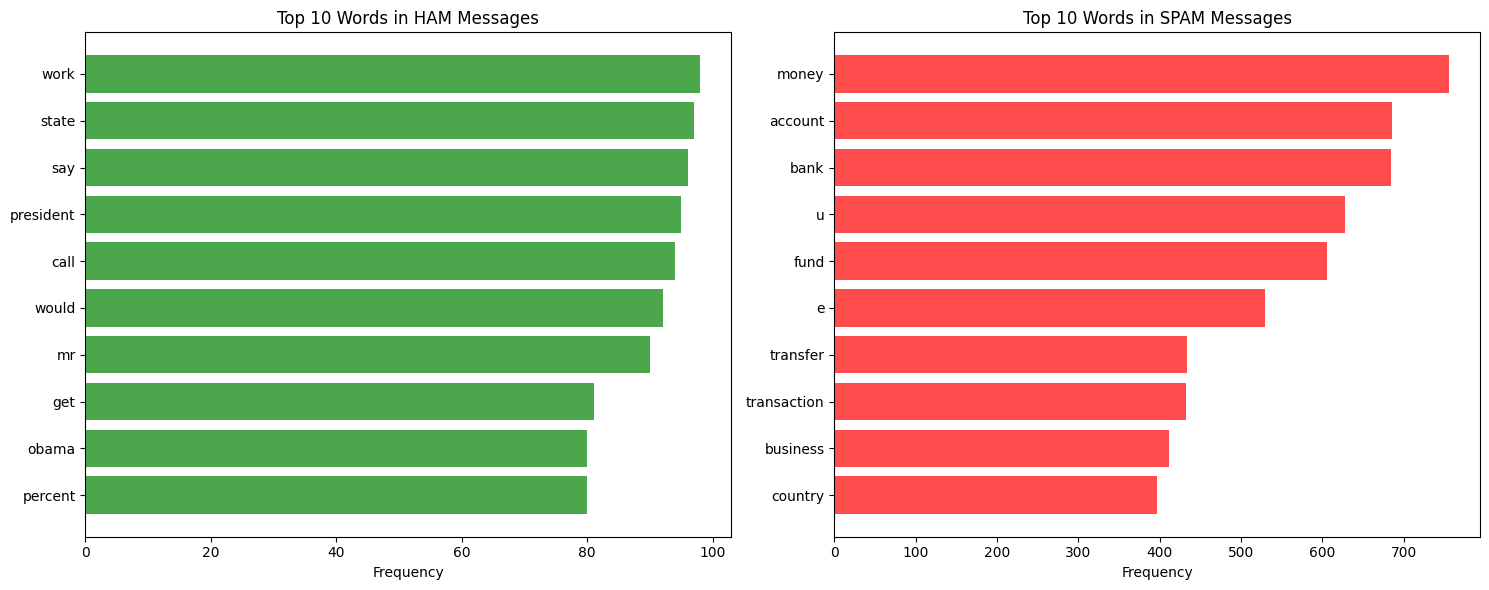


=== WORD ANALYSIS ===
Words appearing in both top-10 lists: set()
Words unique to HAM top-10: {'get', 'call', 'state', 'president', 'say', 'obama', 'work', 'would', 'mr', 'percent'}
Words unique to SPAM top-10: {'u', 'bank', 'fund', 'country', 'e', 'transaction', 'account', 'money', 'business', 'transfer'}

=== TEXT LENGTH STATISTICS ===
Average words per HAM message (label=0): 40.0
Max words in HAM: 2218
Min words in HAM: 0
Average words per SPAM message (label=1): 245.4
Max words in SPAM: 10611
Min words in SPAM: 0


In [25]:
ham_messages = data_train[data_train['label'] == 0]['preprocessed_text']
spam_messages = data_train[data_train['label'] == 1]['preprocessed_text']

print("=== EXPLORATORY DATA ANALYSIS: Top Words ===")
print(f"Total messages in training set: {len(data_train)}")
print(f"Ham messages (label=0): {len(ham_messages)}")
print(f"Spam messages (label=1): {len(spam_messages)}")

# Debug: Check unique labels in your dataset
print(f"Unique labels in dataset: {data_train['label'].unique()}")
print(f"Label counts: {data_train['label'].value_counts()}")
print()

# Check if we have any preprocessed text
print("Sample preprocessed texts:")
for i in range(min(3, len(data_train))):
    print(f"Row {i}: Label='{data_train['label'].iloc[i]}', Text='{data_train['preprocessed_text'].iloc[i][:100]}...'")
print()

# Get top 10 words for each category
top_ham_words = get_top_words(ham_messages, 10) if len(ham_messages) > 0 else []
top_spam_words = get_top_words(spam_messages, 10) if len(spam_messages) > 0 else []

print(f"Found {len(top_ham_words)} ham words")
print(f"Found {len(top_spam_words)} spam words")

print("TOP 10 WORDS IN HAM MESSAGES:")
print("-" * 40)
for i, (word, count) in enumerate(top_ham_words, 1):
    print(f"{i:2d}. {word:<15} ({count:,} occurrences)")

print("\nTOP 10 WORDS IN SPAM MESSAGES:")
print("-" * 40)
for i, (word, count) in enumerate(top_spam_words, 1):
    print(f"{i:2d}. {word:<15} ({count:,} occurrences)")

# Create visualization only if we have data for both categories
if len(top_ham_words) > 0 and len(top_spam_words) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot HAM words
    ham_words, ham_counts = zip(*top_ham_words)
    ax1.barh(range(len(ham_words)), ham_counts, color='green', alpha=0.7)
    ax1.set_yticks(range(len(ham_words)))
    ax1.set_yticklabels(ham_words)
    ax1.set_xlabel('Frequency')
    ax1.set_title('Top 10 Words in HAM Messages')
    ax1.invert_yaxis()

    # Plot SPAM words
    spam_words, spam_counts = zip(*top_spam_words)
    ax2.barh(range(len(spam_words)), spam_counts, color='red', alpha=0.7)
    ax2.set_yticks(range(len(spam_words)))
    ax2.set_yticklabels(spam_words)
    ax2.set_xlabel('Frequency')
    ax2.set_title('Top 10 Words in SPAM Messages')
    ax2.invert_yaxis()

    plt.tight_layout()
    plt.show()
    
    # Find words that appear in both lists
    ham_word_set = set([word for word, count in top_ham_words])
    spam_word_set = set([word for word, count in top_spam_words])
    common_words = ham_word_set.intersection(spam_word_set)
    unique_ham = ham_word_set - spam_word_set
    unique_spam = spam_word_set - ham_word_set

    print(f"\n=== WORD ANALYSIS ===")
    print(f"Words appearing in both top-10 lists: {common_words}")
    print(f"Words unique to HAM top-10: {unique_ham}")
    print(f"Words unique to SPAM top-10: {unique_spam}")
else:
    print("Cannot create visualization - missing data for one or both categories")
    if len(top_ham_words) == 0:
        print("No HAM words found - check your label values")
    if len(top_spam_words) == 0:
        print("No SPAM words found - check your label values")

# Calculate basic statistics - with error handling
print(f"\n=== TEXT LENGTH STATISTICS ===")
if len(ham_messages) > 0:
    ham_lengths = [len(text.split()) for text in ham_messages]
    print(f"Average words per HAM message (label=0): {sum(ham_lengths)/len(ham_lengths):.1f}")
    print(f"Max words in HAM: {max(ham_lengths)}")
    print(f"Min words in HAM: {min(ham_lengths)}")
else:
    print("No HAM messages found")

if len(spam_messages) > 0:
    spam_lengths = [len(text.split()) for text in spam_messages]
    print(f"Average words per SPAM message (label=1): {sum(spam_lengths)/len(spam_lengths):.1f}")
    print(f"Max words in SPAM: {max(spam_lengths)}")
    print(f"Min words in SPAM: {min(spam_lengths)}")
else:
    print("No SPAM messages found")

## Extra features

In [ ]:
# We add to the original dataframe two additional indicators (money symbols and suspicious words).
money_simbol_list = "|".join(["euro","dollar","pound","€",r"\$"])
suspicious_words = "|".join(["free","cheap","sex","money","account","bank","fund","transfer","transaction","win","deposit","password"])

data_train['money_mark'] = data_train['preprocessed_text'].str.contains(money_simbol_list)*1
data_train['suspicious_words'] = data_train['preprocessed_text'].str.contains(suspicious_words)*1
data_train['text_len'] = data_train['preprocessed_text'].apply(lambda x: len(x)) 

data_val['money_mark'] = data_val['preprocessed_text'].str.contains(money_simbol_list)*1
data_val['suspicious_words'] = data_val['preprocessed_text'].str.contains(suspicious_words)*1
data_val['text_len'] = data_val['preprocessed_text'].apply(lambda x: len(x)) 

data_train.head()

## How would work the Bag of Words with Count Vectorizer concept?

In [ ]:
# Your code


## TF-IDF

- Load the vectorizer

- Vectorize all dataset

- print the shape of the vetorized dataset

In [ ]:
# Your code

## And the Train a Classifier?

In [ ]:
# Your code

### Extra Task - Implement a SPAM/HAM classifier

https://www.kaggle.com/t/b384e34013d54d238490103bc3c360ce

The classifier can not be changed!!! It must be the MultinimialNB with default parameters!

Your task is to **find the most relevant features**.

For example, you can test the following options and check which of them performs better:
- Using "Bag of Words" only
- Using "TF-IDF" only
- Bag of Words + extra flags (money_mark, suspicious_words, text_len)
- TF-IDF + extra flags


You can work with teams of two persons (recommended).

In [ ]:
# Your code